In [51]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import localConfig
import random
import seaborn as sns
import os
import re
import gc

In [52]:
# 行列Hをテンソルに変換
def matrix_to_tensor(H, m, n):
    H_tensor = np.zeros((m, m, n, n))
    for i in range(m):
        for j in range(m):
            for k in range(n):
                for l in range(n):
                    H_tensor[i, j, k, l] = H[i * m + j, k * n + l]
    return H_tensor

# テンソルHを使ってHfを計算
def transform_image(H_tensor, f):
    m, _, n, _ = H_tensor.shape
    g = np.zeros((m, m))
    for i in range(m):
        for j in range(m):
            for k in range(n):
                for l in range(n):
                    g[i, j] += H_tensor[i, j, k, l] * f[k, l]
    return g

In [53]:
# folder_pathにある画像を読み込んで行列に変換
def images_to_matrix(folder_path, convert_gray=False, is_binary=False, seed=0, ratio=1.0, use_all=False):
    files = os.listdir(folder_path)
    files.sort(key=lambda f: int(re.search('hadamard_(\d+).png', f).group(1)))

    if seed != 0:
        random.seed(seed)
        random.shuffle(files)

    total_files = len(files)
    number_of_files_to_load = int(total_files * ratio)

    if use_all:
        selected_files = files[:number_of_files_to_load]
        selected_files.sort(key=lambda f: int(re.search('hadamard_(\d+).png', f).group(1)))
    else:
        selected_indices = []
        a = np.arange(0, 4096).reshape(64, 64)
        a = np.triu(a)
        a = a.flatten().tolist()
        selected_indices = [i for i in a if i != 0]
        selected_indices.insert(0, 0)
        # for i in range(0, 64):
        #     range_i= list(range(63+63*i, 64*(i+1)))
        #     selected_indices += range_i
        selected_files = [files[i] for i in selected_indices if i < total_files]

    images = []
    use_list = []

    for file in selected_files:
        index = int(re.sub(r'\D', '', file))
        use_list.append(index)
        img = Image.open(os.path.join(folder_path, file))
        img = img.convert('L')
        if is_binary:
            img = img.point(lambda _: 255 if _ else 0, 'L')
        img_array = np.asarray(img).flatten()
        img_array = img_array / 255
        images.append(img_array)

    # diff = list(set(range(1, len(files)+1))-set(use_list))
    # print("Didn't use:", sorted(diff))
    # print("Used:", use_list)

    return np.column_stack(images)


# FISTAでHを求める
def update_H(H, G, F, lmd, threshold):
    i = 1
    t = 1
    L = max_eigenvalue(F.T @ F) * 3
    print('L: {}'.format(L))
    H_1_prev = H.copy()
    H_2_prev = H.copy()
    while True:
        t_new = (1 + np.sqrt(1 + 4 * t**2)) / 2
        grad = 2 * (H_2_prev @ F - G) @ F.T
        H_1 = soft_thresh(H_2_prev - (1 / L) * grad, lmd / L)
        H_2 = H_1 + (t - 1) / t_new * (H_1 - H_1_prev)
        error = np.linalg.norm(H_2 - H_2_prev, 'fro')

        print('iter: {}, error: {}'.format(i, error))
        if error < threshold:
            break
        t = t_new.copy()
        H_1_prev = H_1.copy()
        H_2_prev = H_2.copy()
        i += 1
    return H_2


def max_eigenvalue(A):
    eigenvalues, eigenvectors = np.linalg.eig(A)
    return np.max(eigenvalues)


def soft_thresh(x, lambda_val):
    return np.sign(x) * np.maximum(np.abs(x) - lambda_val, 0)

In [54]:
# パラメータ設定
n = 64
m = 128
lmd = 10
threshold = 0.001
seed = 0

In [55]:
# 真のシステム行列の計算
G_full = images_to_matrix(localConfig.DATA_PATH + '/hadamard' + str(n) + '_cap_R_230516_128/', convert_gray=True, use_all=True)
F_full = images_to_matrix(localConfig.DATA_PATH + '/Hadamard' + str(n) + '_input/', is_binary=True, use_all=True)
H1 = np.zeros((m**2, n**2))
G1s = []
for i in range(n**2):
    G1s.append(G_full[:, 0])
H1 = np.column_stack(G1s)
F_hat_full = 2 * F_full - 1
G_hat_full = 2 * G_full - H1
H_true = G_hat_full @ F_hat_full.T / (n**2)

<AxesSubplot:>

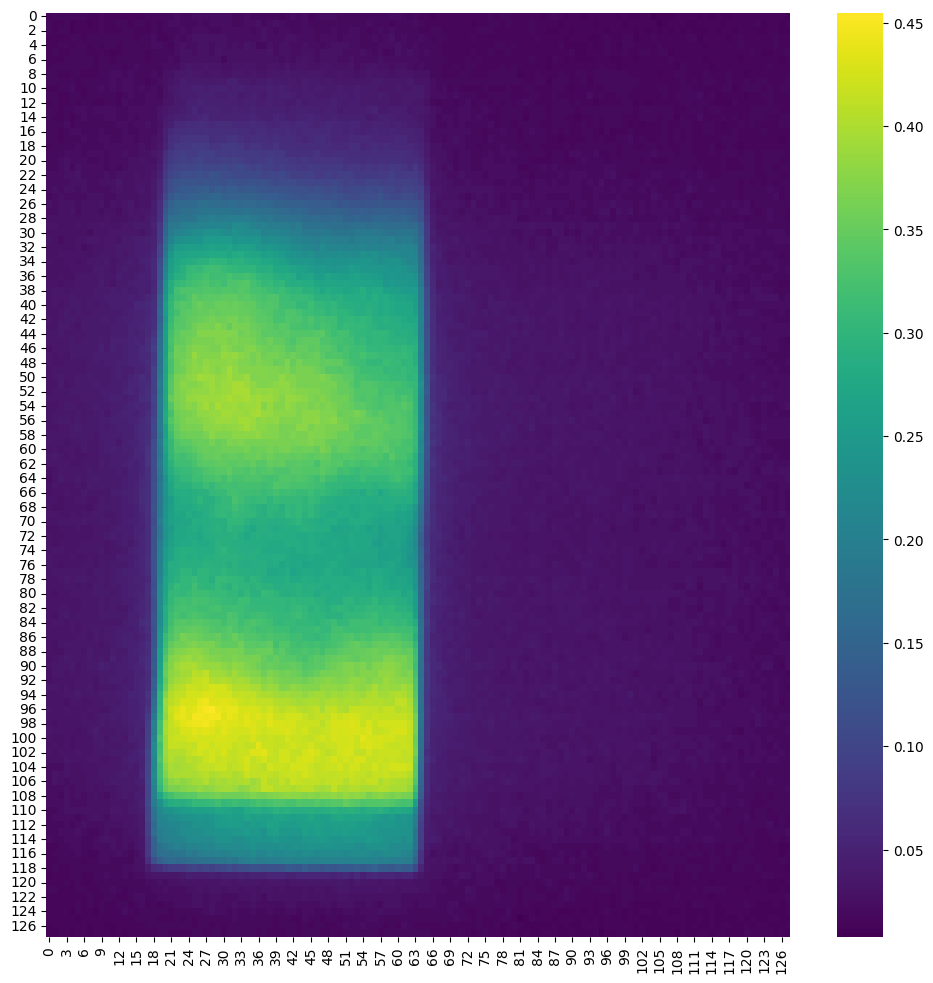

In [56]:
plt.figure(figsize=(12, 12))
sns.heatmap(G_full[:, 1].reshape(m, m), annot=False, cmap='viridis')

In [57]:
np.save(localConfig.DATA_PATH + '/systemMatrix/H_matrix_true.npy', H_true)